# Data Preprocessing

In [1]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
from Bio import SeqIO
from copy import deepcopy

# Set device
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: cuda


### Load tensors from precomputed ESM embeddings folders

In [2]:
def load_tensors_from_directory(directory):
    tensors = []
    try:
        for filename in tqdm(os.listdir(directory), desc=f"Loading {directory}"):
            file_path = os.path.join(directory, filename)
            if os.path.isfile(file_path):
                tensor = torch.load(file_path, weights_only=True)
                tensors.append(tensor)
        return torch.stack(tensors)
    except Exception as e:
        print(f"Error reading directory {directory}: {e}")
        return None

# Stack into tensors
positive_embeddings = load_tensors_from_directory('positive_protein_embeddings')
negative_embeddings = load_tensors_from_directory('negative_protein_embeddings')


Loading negative_protein_embeddings: 100%|██████████| 6677/6677 [00:15<00:00, 422.06it/s]


### Create Labeled Dataset

In [3]:
# Create labels
positive_labels = torch.ones(len(positive_embeddings))
negative_labels = torch.zeros(len(negative_embeddings))

# Combine embeddings with labels
all_embeddings = torch.cat([positive_embeddings, negative_embeddings], dim=0)
all_labels = torch.cat([positive_labels, negative_labels], dim=0)

print(f"\nCombined embeddings shape: {all_embeddings.shape}")
print(f"Combined labels shape: {all_labels.shape}")


Combined embeddings shape: torch.Size([13624, 3072])
Combined labels shape: torch.Size([13624])


### Create a 70/15/15 Train/Dev/Test split

In [4]:
# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    all_embeddings,
    all_labels,
    test_size=0.3,
    random_state=42,
    stratify=all_labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

# Move to device and ensure correct dtype
X_train = X_train.float().to(device)
X_val = X_val.float().to(device)
X_test = X_test.float().to(device)
y_train = y_train.long().to(device)
y_val = y_val.long().to(device)
y_test = y_test.long().to(device)

# Print shapes and class distributions
print("\nData split summary:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"  Positive: {torch.sum(y_train == 1)} ({torch.sum(y_train == 1)/len(y_train)*100:.1f}%)")
print(f"  Negative: {torch.sum(y_train == 0)} ({torch.sum(y_train == 0)/len(y_train)*100:.1f}%)")

print(f"\nValidation set: {X_val.shape[0]} samples")
print(f"  Positive: {torch.sum(y_val == 1)} ({torch.sum(y_val == 1)/len(y_val)*100:.1f}%)")
print(f"  Negative: {torch.sum(y_val == 0)} ({torch.sum(y_val == 0)/len(y_val)*100:.1f}%)")

print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  Positive: {torch.sum(y_test == 1)} ({torch.sum(y_test == 1)/len(y_test)*100:.1f}%)")
print(f"  Negative: {torch.sum(y_test == 0)} ({torch.sum(y_test == 0)/len(y_test)*100:.1f}%)")

# Create DataLoader with float labels
train_dataset = torch.utils.data.TensorDataset(X_train, y_train.float())
val_dataset = torch.utils.data.TensorDataset(X_val, y_val.float())
test_dataset = torch.utils.data.TensorDataset(X_test, y_test.float())

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Data split summary:
Training set: 9536 samples
  Positive: 4862 (51.0%)
  Negative: 4674 (49.0%)

Validation set: 2044 samples
  Positive: 1043 (51.0%)
  Negative: 1001 (49.0%)

Test set: 2044 samples
  Positive: 1042 (51.0%)
  Negative: 1002 (49.0%)


# Test Simple Neural Network for Binary Classification

In [5]:
class ProteinClassifier(nn.Module):
    def __init__(self, input_dim=3072, hidden_dim=1024):
        super().__init__()
        # Larger network with batch normalization
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.BatchNorm1d(hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(hidden_dim // 2, hidden_dim // 4),
            nn.BatchNorm1d(hidden_dim // 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            nn.Linear(hidden_dim // 4, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x).squeeze()

# Initialize model, loss function, and optimizer
model = ProteinClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003, weight_decay=1e-5)

# Training function with gradient clipping to avoid exploding graidents
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    total_loss = 0
    predictions = []
    true_labels = []
    
    for inputs, labels in tqdm(train_loader, desc="Training"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Normalize inputs
        inputs = (inputs - inputs.mean(dim=1, keepdim=True)) / (inputs.std(dim=1, keepdim=True) + 1e-8)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        predictions.extend((outputs > 0.5).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(train_loader), predictions, true_labels

# Evaluation function
def evaluate(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            # Normalize inputs
            inputs = (inputs - inputs.mean(dim=1, keepdim=True)) / (inputs.std(dim=1, keepdim=True) + 1e-8)
            outputs = model(inputs)
            predictions.extend((outputs > 0.5).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return {
        'accuracy': accuracy_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions, zero_division=0),
        'recall': recall_score(true_labels, predictions, zero_division=0),
        'f1': f1_score(true_labels, predictions, zero_division=0)
    }

# Training loop
n_epochs = 30
train_losses = []
val_metrics = []

for epoch in range(n_epochs):
    # Train
    loss, train_preds, train_labels = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(loss)
    
    # Evaluate
    train_metrics = evaluate(model, train_loader)
    val_metrics_epoch = evaluate(model, val_loader)
    val_metrics.append(val_metrics_epoch)
    
    print(f"\nEpoch {epoch+1}/{n_epochs}")
    print(f"Train Loss: {loss:.4f}")
    print(f"Train Metrics: Accuracy={train_metrics['accuracy']:.4f}, F1={train_metrics['f1']:.4f}")
    print(f"Val Metrics: Accuracy={val_metrics_epoch['accuracy']:.4f}, F1={val_metrics_epoch['f1']:.4f}")

# Final evaluation on test set
test_metrics = evaluate(model, test_loader)
print("\nFinal Test Set Metrics:")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")

Training: 100%|██████████| 149/149 [00:01<00:00, 139.24it/s]



Epoch 1/30
Train Loss: 0.4939
Train Metrics: Accuracy=0.8199, F1=0.8303
Val Metrics: Accuracy=0.7921, F1=0.8026


Training: 100%|██████████| 149/149 [00:00<00:00, 186.37it/s]



Epoch 2/30
Train Loss: 0.4105
Train Metrics: Accuracy=0.8561, F1=0.8644
Val Metrics: Accuracy=0.8131, F1=0.8248


Training: 100%|██████████| 149/149 [00:00<00:00, 185.16it/s]



Epoch 3/30
Train Loss: 0.3651
Train Metrics: Accuracy=0.8813, F1=0.8840
Val Metrics: Accuracy=0.8185, F1=0.8222


Training: 100%|██████████| 149/149 [00:00<00:00, 185.55it/s]



Epoch 4/30
Train Loss: 0.3194
Train Metrics: Accuracy=0.8987, F1=0.9050
Val Metrics: Accuracy=0.8312, F1=0.8442


Training: 100%|██████████| 149/149 [00:00<00:00, 186.12it/s]



Epoch 5/30
Train Loss: 0.2893
Train Metrics: Accuracy=0.9151, F1=0.9147
Val Metrics: Accuracy=0.8337, F1=0.8313


Training: 100%|██████████| 149/149 [00:00<00:00, 185.75it/s]



Epoch 6/30
Train Loss: 0.2518
Train Metrics: Accuracy=0.9340, F1=0.9359
Val Metrics: Accuracy=0.8420, F1=0.8468


Training: 100%|██████████| 149/149 [00:00<00:00, 184.87it/s]



Epoch 7/30
Train Loss: 0.2203
Train Metrics: Accuracy=0.9315, F1=0.9349
Val Metrics: Accuracy=0.8439, F1=0.8527


Training: 100%|██████████| 149/149 [00:00<00:00, 184.48it/s]



Epoch 8/30
Train Loss: 0.2079
Train Metrics: Accuracy=0.9443, F1=0.9472
Val Metrics: Accuracy=0.8439, F1=0.8551


Training: 100%|██████████| 149/149 [00:00<00:00, 185.31it/s]



Epoch 9/30
Train Loss: 0.1821
Train Metrics: Accuracy=0.9567, F1=0.9580
Val Metrics: Accuracy=0.8571, F1=0.8616


Training: 100%|██████████| 149/149 [00:00<00:00, 185.77it/s]



Epoch 10/30
Train Loss: 0.1640
Train Metrics: Accuracy=0.9707, F1=0.9715
Val Metrics: Accuracy=0.8576, F1=0.8631


Training: 100%|██████████| 149/149 [00:00<00:00, 184.32it/s]



Epoch 11/30
Train Loss: 0.1502
Train Metrics: Accuracy=0.9664, F1=0.9672
Val Metrics: Accuracy=0.8415, F1=0.8456


Training: 100%|██████████| 149/149 [00:00<00:00, 184.85it/s]



Epoch 12/30
Train Loss: 0.1326
Train Metrics: Accuracy=0.9773, F1=0.9779
Val Metrics: Accuracy=0.8606, F1=0.8641


Training: 100%|██████████| 149/149 [00:00<00:00, 184.85it/s]



Epoch 13/30
Train Loss: 0.1234
Train Metrics: Accuracy=0.9741, F1=0.9748
Val Metrics: Accuracy=0.8425, F1=0.8495


Training: 100%|██████████| 149/149 [00:00<00:00, 183.87it/s]



Epoch 14/30
Train Loss: 0.1175
Train Metrics: Accuracy=0.9859, F1=0.9863
Val Metrics: Accuracy=0.8611, F1=0.8662


Training: 100%|██████████| 149/149 [00:00<00:00, 186.08it/s]



Epoch 15/30
Train Loss: 0.1130
Train Metrics: Accuracy=0.9839, F1=0.9842
Val Metrics: Accuracy=0.8694, F1=0.8732


Training: 100%|██████████| 149/149 [00:00<00:00, 185.46it/s]



Epoch 16/30
Train Loss: 0.1027
Train Metrics: Accuracy=0.9832, F1=0.9835
Val Metrics: Accuracy=0.8483, F1=0.8510


Training: 100%|██████████| 149/149 [00:00<00:00, 184.73it/s]



Epoch 17/30
Train Loss: 0.1010
Train Metrics: Accuracy=0.9746, F1=0.9754
Val Metrics: Accuracy=0.8454, F1=0.8512


Training: 100%|██████████| 149/149 [00:00<00:00, 184.77it/s]



Epoch 18/30
Train Loss: 0.0850
Train Metrics: Accuracy=0.9892, F1=0.9895
Val Metrics: Accuracy=0.8552, F1=0.8617


Training: 100%|██████████| 149/149 [00:00<00:00, 184.68it/s]



Epoch 19/30
Train Loss: 0.0794
Train Metrics: Accuracy=0.9859, F1=0.9863
Val Metrics: Accuracy=0.8552, F1=0.8612


Training: 100%|██████████| 149/149 [00:00<00:00, 185.05it/s]



Epoch 20/30
Train Loss: 0.0825
Train Metrics: Accuracy=0.9841, F1=0.9843
Val Metrics: Accuracy=0.8444, F1=0.8465


Training: 100%|██████████| 149/149 [00:00<00:00, 185.34it/s]



Epoch 21/30
Train Loss: 0.0716
Train Metrics: Accuracy=0.9929, F1=0.9930
Val Metrics: Accuracy=0.8523, F1=0.8559


Training: 100%|██████████| 149/149 [00:00<00:00, 185.44it/s]



Epoch 22/30
Train Loss: 0.0726
Train Metrics: Accuracy=0.9923, F1=0.9925
Val Metrics: Accuracy=0.8640, F1=0.8675


Training: 100%|██████████| 149/149 [00:00<00:00, 186.60it/s]



Epoch 23/30
Train Loss: 0.0755
Train Metrics: Accuracy=0.9915, F1=0.9917
Val Metrics: Accuracy=0.8483, F1=0.8529


Training: 100%|██████████| 149/149 [00:00<00:00, 185.21it/s]



Epoch 24/30
Train Loss: 0.0635
Train Metrics: Accuracy=0.9915, F1=0.9917
Val Metrics: Accuracy=0.8620, F1=0.8682


Training: 100%|██████████| 149/149 [00:00<00:00, 185.74it/s]



Epoch 25/30
Train Loss: 0.0594
Train Metrics: Accuracy=0.9930, F1=0.9931
Val Metrics: Accuracy=0.8493, F1=0.8529


Training: 100%|██████████| 149/149 [00:00<00:00, 185.70it/s]



Epoch 26/30
Train Loss: 0.0592
Train Metrics: Accuracy=0.9935, F1=0.9936
Val Metrics: Accuracy=0.8523, F1=0.8531


Training: 100%|██████████| 149/149 [00:00<00:00, 184.90it/s]



Epoch 27/30
Train Loss: 0.0654
Train Metrics: Accuracy=0.9938, F1=0.9939
Val Metrics: Accuracy=0.8547, F1=0.8558


Training: 100%|██████████| 149/149 [00:00<00:00, 186.46it/s]



Epoch 28/30
Train Loss: 0.0562
Train Metrics: Accuracy=0.9934, F1=0.9935
Val Metrics: Accuracy=0.8508, F1=0.8540


Training: 100%|██████████| 149/149 [00:00<00:00, 187.67it/s]



Epoch 29/30
Train Loss: 0.0548
Train Metrics: Accuracy=0.9945, F1=0.9947
Val Metrics: Accuracy=0.8601, F1=0.8628


Training: 100%|██████████| 149/149 [00:00<00:00, 186.13it/s]



Epoch 30/30
Train Loss: 0.0538
Train Metrics: Accuracy=0.9948, F1=0.9949
Val Metrics: Accuracy=0.8620, F1=0.8694

Final Test Set Metrics:
Accuracy: 0.8596
Precision: 0.8410
Recall: 0.8935
F1 Score: 0.8664


### Plot Traning Curves

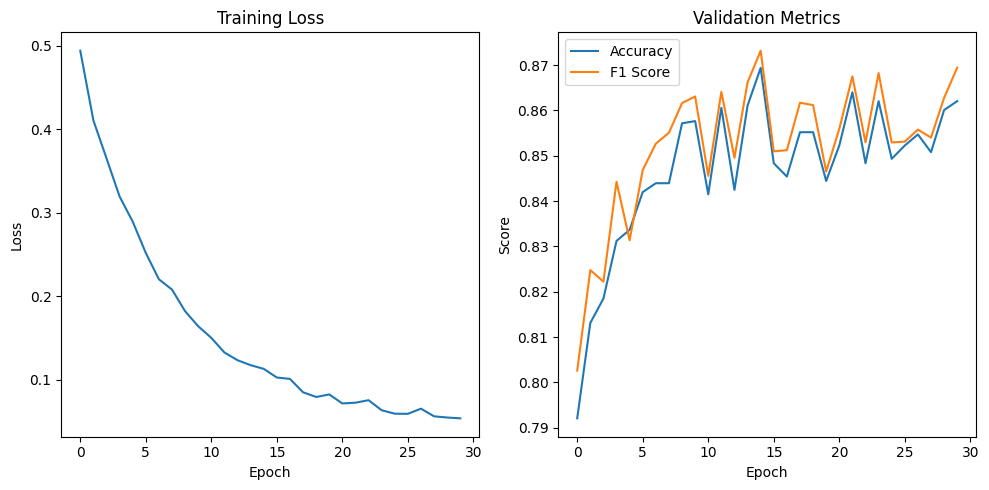

In [6]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot([m['accuracy'] for m in val_metrics], label='Accuracy')
plt.plot([m['f1'] for m in val_metrics], label='F1 Score')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.tight_layout()
plt.show()

# Comprehensive Training Suite to compare Neural Network Models with different hyperparameters


Training Logistic Regression...



Epoch 5/50
Train Loss: 0.4884
Train Metrics: Accuracy=0.7582, F1=0.7723
Val Metrics: Accuracy=0.7549, F1=0.7705



Epoch 10/50
Train Loss: 0.4638
Train Metrics: Accuracy=0.7740, F1=0.7855
Val Metrics: Accuracy=0.7701, F1=0.7816



Epoch 15/50
Train Loss: 0.4501
Train Metrics: Accuracy=0.7855, F1=0.7936
Val Metrics: Accuracy=0.7774, F1=0.7853



Epoch 20/50
Train Loss: 0.4388
Train Metrics: Accuracy=0.7936, F1=0.8006
Val Metrics: Accuracy=0.7896, F1=0.7977



Epoch 25/50
Train Loss: 0.4285
Train Metrics: Accuracy=0.7951, F1=0.8035
Val Metrics: Accuracy=0.7798, F1=0.7891



Epoch 30/50
Train Loss: 0.4237
Train Metrics: Accuracy=0.7979, F1=0.8012
Val Metrics: Accuracy=0.7828, F1=0.7861



Epoch 35/50
Train Loss: 0.4160
Train Metrics: Accuracy=0.8072, F1=0.8229
Val Metrics: Accuracy=0.7906, F1=0.8081



Epoch 40/50
Train Loss: 0.4091
Train Metrics: Accuracy=0.8112, F1=0.8232
Val Metrics: Accuracy=0.7945, F1=0.8082



Epoch 45/50
Train Loss: 0.4116
Train Metrics: Accuracy=0.8150, F1=0.8297
Val Metrics: Accuracy=0.7906, F1=0.8077



Epoch 50/50
Train Loss: 0.3997
Train Metrics: Accuracy=0.8162, F1=0.8317
Val Metrics: Accuracy=0.7994, F1=0.8171

Logistic Regression Final Test Metrics:
Accuracy: 0.7867
Precision: 0.7621
Recall: 0.8455
F1 Score: 0.8016

Training Simple Model...



Epoch 5/50
Train Loss: 0.3418
Train Metrics: Accuracy=0.8661, F1=0.8687
Val Metrics: Accuracy=0.8214, F1=0.8254



Epoch 10/50
Train Loss: 0.2307
Train Metrics: Accuracy=0.9385, F1=0.9398
Val Metrics: Accuracy=0.8523, F1=0.8563



Epoch 15/50
Train Loss: 0.1541
Train Metrics: Accuracy=0.9735, F1=0.9741
Val Metrics: Accuracy=0.8537, F1=0.8584



Epoch 20/50
Train Loss: 0.1053
Train Metrics: Accuracy=0.9770, F1=0.9775
Val Metrics: Accuracy=0.8537, F1=0.8580



Epoch 25/50
Train Loss: 0.0752
Train Metrics: Accuracy=0.9864, F1=0.9868
Val Metrics: Accuracy=0.8527, F1=0.8598



Epoch 30/50
Train Loss: 0.0571
Train Metrics: Accuracy=0.9966, F1=0.9967
Val Metrics: Accuracy=0.8606, F1=0.8617



Epoch 35/50
Train Loss: 0.0445
Train Metrics: Accuracy=0.9855, F1=0.9860
Val Metrics: Accuracy=0.8645, F1=0.8747



Epoch 40/50
Train Loss: 0.0298
Train Metrics: Accuracy=0.9980, F1=0.9980
Val Metrics: Accuracy=0.8615, F1=0.8630



Epoch 45/50
Train Loss: 0.0271
Train Metrics: Accuracy=0.9984, F1=0.9985
Val Metrics: Accuracy=0.8674, F1=0.8684



Epoch 50/50
Train Loss: 0.0300
Train Metrics: Accuracy=0.9945, F1=0.9947
Val Metrics: Accuracy=0.8567, F1=0.8615

Simple Model Final Test Metrics:
Accuracy: 0.8532
Precision: 0.8540
Recall: 0.8589
F1 Score: 0.8565

Training Medium Model...



Epoch 5/50
Train Loss: 0.2789
Train Metrics: Accuracy=0.9220, F1=0.9267
Val Metrics: Accuracy=0.8488, F1=0.8605



Epoch 10/50
Train Loss: 0.1648
Train Metrics: Accuracy=0.9691, F1=0.9696
Val Metrics: Accuracy=0.8469, F1=0.8475



Epoch 15/50
Train Loss: 0.1120
Train Metrics: Accuracy=0.9782, F1=0.9789
Val Metrics: Accuracy=0.8562, F1=0.8624



Epoch 20/50
Train Loss: 0.0790
Train Metrics: Accuracy=0.9902, F1=0.9904
Val Metrics: Accuracy=0.8625, F1=0.8668



Epoch 25/50
Train Loss: 0.0711
Train Metrics: Accuracy=0.9904, F1=0.9906
Val Metrics: Accuracy=0.8586, F1=0.8659



Epoch 30/50
Train Loss: 0.0602
Train Metrics: Accuracy=0.9928, F1=0.9929
Val Metrics: Accuracy=0.8493, F1=0.8498



Epoch 35/50
Train Loss: 0.0428
Train Metrics: Accuracy=0.9955, F1=0.9956
Val Metrics: Accuracy=0.8635, F1=0.8690



Epoch 40/50
Train Loss: 0.0417
Train Metrics: Accuracy=0.9979, F1=0.9979
Val Metrics: Accuracy=0.8684, F1=0.8721



Epoch 45/50
Train Loss: 0.0364
Train Metrics: Accuracy=0.9958, F1=0.9959
Val Metrics: Accuracy=0.8664, F1=0.8726



Epoch 50/50
Train Loss: 0.0376
Train Metrics: Accuracy=0.9983, F1=0.9984
Val Metrics: Accuracy=0.8586, F1=0.8587

Medium Model Final Test Metrics:
Accuracy: 0.8620
Precision: 0.8532
Recall: 0.8810
F1 Score: 0.8669

Training Large Model...



Epoch 5/50
Train Loss: 0.3216
Train Metrics: Accuracy=0.8989, F1=0.9055
Val Metrics: Accuracy=0.8346, F1=0.8468



Epoch 10/50
Train Loss: 0.2220
Train Metrics: Accuracy=0.9536, F1=0.9561
Val Metrics: Accuracy=0.8542, F1=0.8658



Epoch 15/50
Train Loss: 0.1605
Train Metrics: Accuracy=0.9780, F1=0.9786
Val Metrics: Accuracy=0.8650, F1=0.8719



Epoch 20/50
Train Loss: 0.1162
Train Metrics: Accuracy=0.9689, F1=0.9702
Val Metrics: Accuracy=0.8615, F1=0.8717



Epoch 25/50
Train Loss: 0.0988
Train Metrics: Accuracy=0.9875, F1=0.9878
Val Metrics: Accuracy=0.8694, F1=0.8711



Epoch 30/50
Train Loss: 0.0887
Train Metrics: Accuracy=0.9934, F1=0.9935
Val Metrics: Accuracy=0.8674, F1=0.8731



Epoch 35/50
Train Loss: 0.0784
Train Metrics: Accuracy=0.9894, F1=0.9897
Val Metrics: Accuracy=0.8640, F1=0.8734



Epoch 40/50
Train Loss: 0.0699
Train Metrics: Accuracy=0.9963, F1=0.9964
Val Metrics: Accuracy=0.8718, F1=0.8750



Epoch 45/50
Train Loss: 0.0630
Train Metrics: Accuracy=0.9931, F1=0.9932
Val Metrics: Accuracy=0.8547, F1=0.8615



Epoch 50/50
Train Loss: 0.0523
Train Metrics: Accuracy=0.9944, F1=0.9946
Val Metrics: Accuracy=0.8748, F1=0.8804

Large Model Final Test Metrics:
Accuracy: 0.8645
Precision: 0.8424
Recall: 0.9031
F1 Score: 0.8717

Training Deep Model...



Epoch 5/50
Train Loss: 0.3310
Train Metrics: Accuracy=0.9018, F1=0.9065
Val Metrics: Accuracy=0.8395, F1=0.8494



Epoch 10/50
Train Loss: 0.2222
Train Metrics: Accuracy=0.9369, F1=0.9391
Val Metrics: Accuracy=0.8425, F1=0.8508



Epoch 15/50
Train Loss: 0.1627
Train Metrics: Accuracy=0.9758, F1=0.9764
Val Metrics: Accuracy=0.8562, F1=0.8604



Epoch 20/50
Train Loss: 0.1303
Train Metrics: Accuracy=0.9825, F1=0.9829
Val Metrics: Accuracy=0.8576, F1=0.8631



Epoch 25/50
Train Loss: 0.0994
Train Metrics: Accuracy=0.9889, F1=0.9891
Val Metrics: Accuracy=0.8606, F1=0.8647



Epoch 30/50
Train Loss: 0.0878
Train Metrics: Accuracy=0.9915, F1=0.9917
Val Metrics: Accuracy=0.8601, F1=0.8645



Epoch 35/50
Train Loss: 0.0826
Train Metrics: Accuracy=0.9914, F1=0.9916
Val Metrics: Accuracy=0.8635, F1=0.8708



Epoch 40/50
Train Loss: 0.0707
Train Metrics: Accuracy=0.9959, F1=0.9960
Val Metrics: Accuracy=0.8630, F1=0.8647



Epoch 45/50
Train Loss: 0.0563
Train Metrics: Accuracy=0.9969, F1=0.9969
Val Metrics: Accuracy=0.8532, F1=0.8565



Epoch 50/50
Train Loss: 0.0541
Train Metrics: Accuracy=0.9963, F1=0.9964
Val Metrics: Accuracy=0.8679, F1=0.8747

Deep Model Final Test Metrics:
Accuracy: 0.8635
Precision: 0.8434
Recall: 0.8992
F1 Score: 0.8704


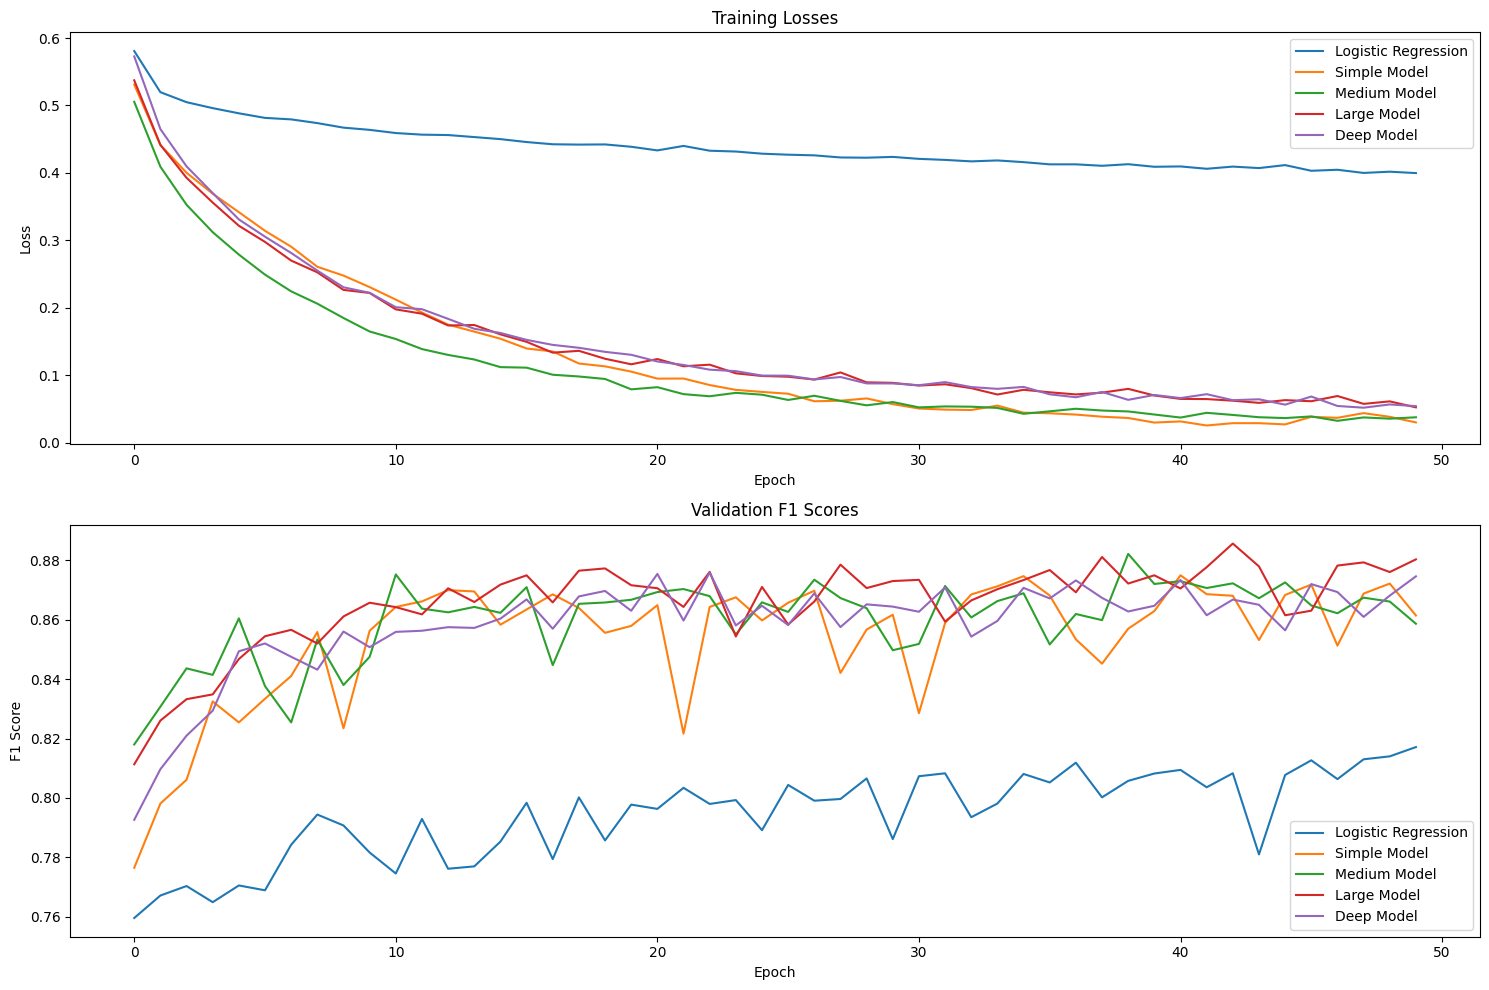


Model Comparison:
--------------------------------------------------------------------------------
Model                Accuracy   Precision  Recall     F1 Score  
--------------------------------------------------------------------------------
Logistic Regression  0.7867     0.7621     0.8455     0.8016
Simple Model         0.8532     0.8540     0.8589     0.8565
Medium Model         0.8620     0.8532     0.8810     0.8669
Large Model          0.8645     0.8424     0.9031     0.8717
Deep Model           0.8635     0.8434     0.8992     0.8704


In [8]:
# Model configurations with different hyperparameters (layers, dropout, learning rates, batch sizes, etc)
model_configs = [
    {
        "name": "Logistic Regression",
        "hidden_dims": [],
        "dropout_rates": [],
        "learning_rate": 0.001,
        "weight_decay": 0,
        "batch_size": 256
    },
    {
        "name": "Simple Model",
        "hidden_dims": [128],
        "dropout_rates": [0.1],
        "learning_rate": 0.001,
        "weight_decay": 0,
        "batch_size": 256
    },
    {
        "name": "Medium Model",
        "hidden_dims": [512, 256, 128],
        "dropout_rates": [0.2, 0.2, 0.1],
        "learning_rate": 0.0003,
        "weight_decay": 1e-5,
        "batch_size": 128
    },
    {
        "name": "Large Model",
        "hidden_dims": [1024, 512, 256, 128],
        "dropout_rates": [0.3, 0.3, 0.2, 0.1],
        "learning_rate": 0.0001,
        "weight_decay": 1e-5,
        "batch_size": 64
    },
    {
        "name": "Deep Model",
        "hidden_dims": [512, 256, 128, 64, 32],
        "dropout_rates": [0.2, 0.2, 0.2, 0.1, 0.1],
        "learning_rate": 0.0002,
        "weight_decay": 1e-5,
        "batch_size": 96
    }
]
class ProteinClassifier(nn.Module):
    def __init__(self, input_dim=3072, hidden_dims=[1024, 512, 256], dropout_rates=[0.2, 0.2, 0.1]):
        super().__init__()
        
        layers = []
        current_dim = input_dim
        
        for i, hidden_dim in enumerate(hidden_dims):
            layers.extend([
                nn.Linear(current_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rates[i])
            ])
            current_dim = hidden_dim
            
        # Output layer
        layers.extend([
            nn.Linear(current_dim, 1),
            nn.Sigmoid()
        ])
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x).squeeze()

def train_and_evaluate_model(config, n_epochs=50):
    print(f"\nTraining {config['name']}...")
    
    # Initialize model
    model = ProteinClassifier(
        hidden_dims=config['hidden_dims'],
        dropout_rates=config['dropout_rates']
    ).to(device)
    
    # Set up training
    criterion = nn.BCELoss()
    optimizer = optim.Adam(
        model.parameters(), 
        lr=config['learning_rate'], 
        weight_decay=config['weight_decay']
    )
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)
    
    train_losses = []
    val_metrics = []
    best_val_f1 = 0
    best_model = None
    
    for epoch in range(n_epochs):
        # Train
        model.train()
        total_loss = 0
        predictions = []
        true_labels = []
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{n_epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Normalize inputs
            inputs = (inputs - inputs.mean(dim=1, keepdim=True)) / (inputs.std(dim=1, keepdim=True) + 1e-8)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_loss += loss.item()
            predictions.extend((outputs > 0.5).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        # Evaluate
        train_metrics = evaluate(model, train_loader)
        val_metrics_epoch = evaluate(model, val_loader)
        val_metrics.append(val_metrics_epoch)
        
        # Save best model to evaluate for the test set
        if val_metrics_epoch['f1'] > best_val_f1:
            best_val_f1 = val_metrics_epoch['f1']
            best_model = deepcopy(model.state_dict())
        
        if (epoch + 1) % 5 == 0:  # Print every 5 epochs
            print(f"\nEpoch {epoch+1}/{n_epochs}")
            print(f"Train Loss: {avg_loss:.4f}")
            print(f"Train Metrics: Accuracy={train_metrics['accuracy']:.4f}, F1={train_metrics['f1']:.4f}")
            print(f"Val Metrics: Accuracy={val_metrics_epoch['accuracy']:.4f}, F1={val_metrics_epoch['f1']:.4f}")
    
    # Load best model and evaluate on test set
    model.load_state_dict(best_model)
    test_metrics = evaluate(model, test_loader)
    
    return {
        'name': config['name'],
        'train_losses': train_losses,
        'val_metrics': val_metrics,
        'test_metrics': test_metrics,
        'model': model
    }

def evaluate(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = (inputs - inputs.mean(dim=1, keepdim=True)) / (inputs.std(dim=1, keepdim=True) + 1e-8)
            outputs = model(inputs)
            predictions.extend((outputs > 0.5).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return {
        'accuracy': accuracy_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions, zero_division=0),
        'recall': recall_score(true_labels, predictions, zero_division=0),
        'f1': f1_score(true_labels, predictions, zero_division=0)
    }

# Train all models
results = []
for config in model_configs:
    result = train_and_evaluate_model(config)
    results.append(result)
    
    print(f"\n{result['name']} Final Test Metrics:")
    print(f"Accuracy: {result['test_metrics']['accuracy']:.4f}")
    print(f"Precision: {result['test_metrics']['precision']:.4f}")
    print(f"Recall: {result['test_metrics']['recall']:.4f}")
    print(f"F1 Score: {result['test_metrics']['f1']:.4f}")

# Plot results
plt.figure(figsize=(15, 10))

# Plot training losses
plt.subplot(2, 1, 1)
for result in results:
    plt.plot(result['train_losses'], label=result['name'])
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation F1 scores
plt.subplot(2, 1, 2)
for result in results:
    f1_scores = [m['f1'] for m in result['val_metrics']]
    plt.plot(f1_scores, label=result['name'])
plt.title('Validation F1 Scores')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

# Print comparison table
print("\nModel Comparison:")
print("-" * 80)
print(f"{'Model':20} {'Accuracy':10} {'Precision':10} {'Recall':10} {'F1 Score':10}")
print("-" * 80)
for result in results:
    metrics = result['test_metrics']
    print(f"{result['name']:20} "
          f"{metrics['accuracy']:.4f}     "
          f"{metrics['precision']:.4f}     "
          f"{metrics['recall']:.4f}     "
          f"{metrics['f1']:.4f}")